In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
from maptools import make_map
import cartopy.io.img_tiles as cimgt
from scipy import linalg
import scipy.stats as stats
import seaborn as sns

Above are all the packages one will need to have installed in their computer in order to run this program, as well as access to maptools which is included in the repository for this project. 

There have been many trophic ecology studies completed regarding single species in order to identify intra-species variability. Differences observed can be attributed to a plethora of reasons: individual biological fish characteristics that contribute to variation in energy resources and allocation. For example, larger, heavier, sexually mature, and female organisms tend to have higher trophic positions as they require more resources or more energetically dense resources in order to sustain their metabolisms. On the other hand, there are studies that find differences in diets within species due to geographic or oceanographic conditions. For example, based on geographic locations, food webs can be drastically different in size, complexity, and biodiversity, thus portraying differences of trophic selections. In addition different habitat types, depths, currents, or oceanographic conditions like pH, temperature, or salinity can influence habitat selection and foraging patterns. Thus it is essential to look at both biological and environmental contributers to trophic ecology studies both together and separately in order to indicate what factors are contributing to trophic variablity the most. Differences in trophic ecology within species has large implications on the ecosystem services and roles within the ecosystem for the species. If this is shifting over spatial distributions, then ecosystem based fisheries management needs to adapt different spatial management regulations. If certain quantitative factors of an environment can be easily measured and used to predict or descrbe these highly variable ecological interactions, fisheries management practices could become more specialized and thus effective over broad spatial distances. 

This code was constructed in order to run 3 different PCAs for Canary Rockfish data along the California Current System (CCS) as a part of preliminary data analysis for my thesis. My thesis partially concerns the trophic ecology of the canary rockfish along the CCS. Therefore, the PCAs ran within this code have been broken into 3 different categories in order to understand how trophic position based on stable isotopes δ15N and δ13C, are varying based on a multitude of biological and environmental factors. I have indicated that total length, weight, Fulton's K, GSI, and HSI (explained in further depth within the readme.md file) to be biological indicators of individual fish characteristics, and latitude, longitude, depth, relief, and managment zone latitude to be environmental indicators. I chose to run these groupings separately and together in order to see which of the factors is contributing to the most variance in trophic position based on different scales. 

## __METHODS AND DATA SOURCES:__

#### Map of Sampling Locations

In [2]:
ccs = [-116,-128,52,30] #california current system coordinates 
longitude = [-114,-130] #longitude coordinates
#mgmt region coordinates 
latitudem = [36,36]
latitudee = [40.1,40.1]
latitudec = [43,43]
latitudev = [47.3,47.3]

/Users/michaelamelanson/opt/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/michaelamelanson/opt/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


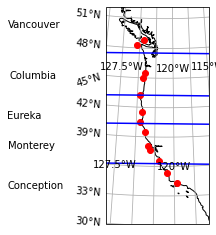

In [3]:
plt.figure()
ax = make_map(projection=ccrs.LambertConformal(central_longitude=-121, central_latitude = 40))
ax.set_extent(ccs)
plt.plot(-120.93,35.29,'ro',transform=ccrs.PlateCarree()) #morro bay
plt.plot(-125.37,48.25,'ro',transform=ccrs.PlateCarree()) #neah bay 
plt.plot(-124.35,48.87,'ro',transform=ccrs.PlateCarree()) #westport
plt.plot(-124.02, 45.50,'ro',transform=ccrs.PlateCarree()) #garibaldi
plt.plot(-124.62, 43.23,'ro',transform=ccrs.PlateCarree()) #coos bay
plt.plot(-124.23,41.51,'ro',transform=ccrs.PlateCarree()) #brookings
plt.plot(-123.84, 39.52,'ro',transform=ccrs.PlateCarree()) #fort bragg
plt.plot(-123.08,37.69,'ro',transform=ccrs.PlateCarree()) #half moon bay
plt.plot(-121.96, 36.54,'ro',transform=ccrs.PlateCarree()) #moss
plt.plot(-123.40,38.06,'ro',transform=ccrs.PlateCarree()) #bodega bay
plt.plot(-124.35,44.97,'ro',transform=ccrs.PlateCarree()) #newport
plt.plot(-119.73,34.36,'ro',transform=ccrs.PlateCarree()) #conception
plt.plot(-124.45,40.49,'ro',transform=ccrs.PlateCarree()) #eureka
plt.text(-140,32,'Conception', transform=ccrs.PlateCarree())
plt.plot(longitude,latitudem, '-',color='blue', transform=ccrs.PlateCarree())#montereymgmt
plt.text(-141,36,'Monterey', transform=ccrs.PlateCarree())
plt.plot(longitude,latitudee, '-',color='blue', transform=ccrs.PlateCarree()) #eurekamgmt
plt.text(-142,39,'Eureka', transform=ccrs.PlateCarree())
plt.plot(longitude,latitudec, '-',color='blue', transform=ccrs.PlateCarree()) #columbiamgmt
plt.text(-143,43,'Columbia', transform=ccrs.PlateCarree())
plt.plot(longitude,latitudev, '-',color='blue', transform=ccrs.PlateCarree()) #vancouvermgmt
plt.text(-145,48,'Vancouver', transform=ccrs.PlateCarree())
ax.coastlines()

## __RESULTS:__

#### PCA

In [4]:
#subsetting the different data sets: biological characteristics, environmental characteristics and both
data = pd.read_csv('pythonproject.csv')
df = data[['TL cm', "Fulton's K", 'GSI (g)', 'HSI (g)', 'Weight', 'mgmt_lat', 'Depth m', 'Lat', 'Long', 'Relief' ]]
bio = data[['TL cm', "Fulton's K", 'GSI (g)', 'HSI (g)', 'Weight']]
env = data[['mgmt_lat', 'Depth m', 'Lat', 'Long', 'Relief']]

In [23]:
#dropping Na values from dataset
df = df.dropna()
bio = bio.dropna()
env = env.dropna()

In [6]:
#creating numpy arrays from the panda dataframes
datanp = df.values
bionp = bio.values
envnp = env.values

In [8]:
#standardizing variables within data sets 
data_norm = (datanp - np.mean(datanp, axis=0))/np.std(datanp, axis = 0, ddof=1)
bio_data_norm = (bionp - np.mean(bionp, axis=0))/np.std(bionp, axis = 0, ddof=1)
env_data_norm = (envnp - np.mean(envnp, axis=0))/np.std(envnp, axis = 0, ddof=1)

#### Correlation/Covariance Matrix

In [9]:
#creating matrices
R1 = np.cov(data_norm, rowvar=False)
R2 = np.cov(bio_data_norm, rowvar=False)
R3 = np.cov(env_data_norm, rowvar=False)

#### Covariance Matrix

In [10]:
#extracting eigenvalues and eigenvectors 
val1, vec1 = linalg.eig(R1)
val2, vec2 = linalg.eig(R2)
val3, vec3 = linalg.eig(R3)

In [11]:
#removing imaginary part from eigenvalues and computing the diagonal
value1 = np.diag(np.real(val1))
value2 = np.diag(np.real(val2))
value3 = np.diag(np.real(val3))
#resorting since the variances were out of order from greatest to least
value1f = value1[[0,1,5,8,9,7,6,4,3,2]]
value2f = value2[[0,3,4,2,1]] 
value3f = value3[[0,4,3,2,1]]

In [12]:
#how much each PC accounts for total variance 
print(value1f/np.sum(value1f))
print(value2f/np.sum(value2f))
print(value3f/np.sum(value3f))

[[0.30800799 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.20255856 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.11872269
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.10043499 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.08962582]
 [0.         0.         0.         0.         0.         0.
  0.         0.07303655 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.05540843 0.         0.         0.        ]
 [0.         0.         0.         0.         0.03093536 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.01776248 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.003

#### Factor Loading Matrix

In [13]:
A = np.matmul(vec1,value1f**.5)
B = np.matmul(vec2,value2f**.5)
C = np.matmul(vec3,value3f**.5)

#### Figures

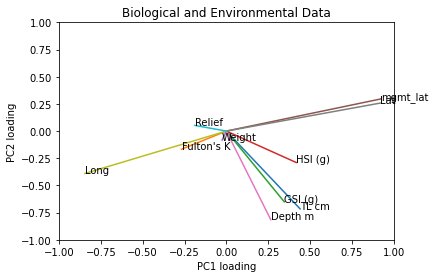

In [14]:
plt.figure()
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')
plt.title('Biological and Environmental Data')

variables = ['TL cm', "Fulton's K", 'GSI (g)', 'HSI (g)', 'Weight', 'mgmt_lat', 'Depth m', 'Lat', 'Long', 'Relief']
for i,txt in enumerate(variables):
    plt.plot([0,A[i,0]],[0,A[i,1]],'-') #plotted PC1 and PC2 
    plt.text(A[i,0],A[i,1],txt)

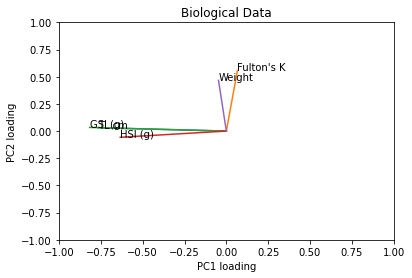

In [15]:
plt.figure()
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')
plt.title('Biological Data')

variables = ['TL cm', "Fulton's K", 'GSI (g)', 'HSI (g)', 'Weight']
for i,txt in enumerate(variables):
    plt.plot([0,B[i,0]],[0,B[i,1]],'-') #plotted PC1 and PC2 
    plt.text(B[i,0],B[i,1],txt)

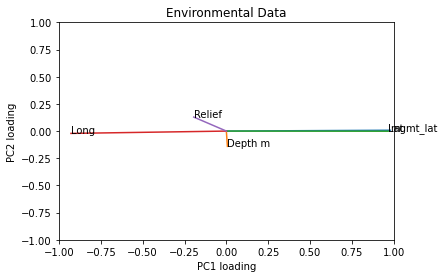

In [16]:
plt.figure()
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.xlabel('PC1 loading')
plt.ylabel('PC2 loading')
plt.title('Environmental Data')

variables = ['mgmt_lat', 'Depth m', 'Lat', 'Long', 'Relief']
for i,txt in enumerate(variables):
    plt.plot([0,C[i,0]],[0,C[i,1]],'-') #plots PC1 and PC2 on x and y axis with factor loadings of each variable 
    plt.text(C[i,0],C[i,1],txt)

If variables are clumped together, it means that they covary (similar direction with respect to origin), with similar magnitudes (similar distance from origin).

### Principal Component Score

In [52]:
tau1 = np.matmul(data_norm,vec1)
tau2 = np.matmul(bio_data_norm,vec2)
tau3 = np.matmul(env_data_norm,vec3)

[[ 1.38511016  1.01303165  0.24314965 ... -1.20666408 -1.17948964
   1.2174264 ]
 [ 1.09203246  0.65670361  0.29818439 ... -0.63078274  0.85173449
  -0.84715381]
 [ 1.08963531  0.88535704  0.28817005 ...  0.23770733 -0.8771753
  -0.03342735]
 ...
 [ 1.35856037  1.76092679 -0.10373225 ... -0.16272549  1.30708931
  -2.14926991]
 [ 2.91320747 -0.95548157 -0.23406426 ...  0.6218879  -0.52803442
  -1.31752447]
 [ 3.19609654 -0.95853411 -0.24254442 ...  0.31123649 -1.83701264
  -0.19587442]]


Text(0.5, 0, 'Individual Samples')

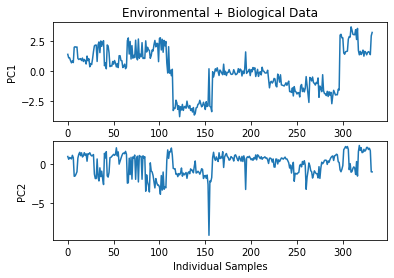

In [61]:
plt.figure()
plt.subplot(211)
plt.title('Environmental + Biological Data')
plt.ylabel('PC1')
plt.plot(tau1[:,0])
plt.subplot(212)
plt.plot(tau1[:,1])
plt.ylabel('PC2')
plt.xlabel('Individual Samples')

Text(0.5, 0, 'Individual Samples')

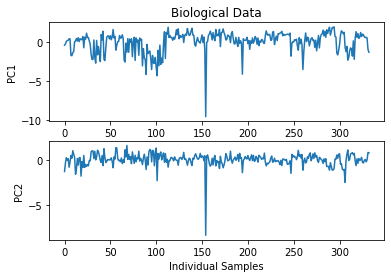

In [62]:
plt.figure()
plt.subplot(211)
plt.title('Biological Data')
plt.plot(tau2[:,0])
plt.ylabel('PC1')
plt.subplot(212)
plt.plot(tau2[:,1])
plt.ylabel('PC2')
plt.xlabel('Individual Samples')

These show your individual samples on the x axis and then how they are represetned by PC1 (top graph) and PC2 (bottom graph)

Text(0.5, 0, 'Individual Samples')

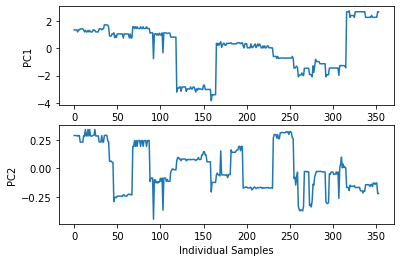

In [58]:
plt.figure()
plt.subplot(211)
plt.title
plt.plot(tau3[:,0])
plt.ylabel('PC1')
plt.subplot(212)
plt.plot(tau3[:,1])
plt.ylabel('PC2')
plt.xlabel('Individual Samples')

## CONCLUSIONS:

From an environmental point of view a large amount of PC1 and thus the overall variance can be attributed to latitude and longitude measurements, thus where these fish are located with the geopgraphy of the CCS. This is evident in both the subset of the environmental factors as well as all the data combined, indicating geographic location to be an important indicator for the trophic position of the canary rockfish along the CCS. Depth and relief contribute to most of the PC2 variance, but in much smaller contribution than latitude and longitude. PC1 encaptures 55% of the total variability and PC2 displays 24% thus totalling 79% of the total variance. 

The latitude given by specific fish captures and the latitude given for each management region appear to vary with the same magnitude and direction, thus it makes it more statistically sound to pick just one of these measurements going forward with future analyses. I will likely use individual latitude values as this encaptures more detailed variability per data point than management latitude values. As well as this parameter coorresponds better to the individual longitude values. 

From a biological point of view, PC1 encaptures the variance of GSI, HSI, and total length and PC2 for weight and Fulton's K. This is a little different from what I expected, as length is used in calculating Fulton's K and GSI whereas weight is used to calculate HSI and Fulton's K, yet some of these variables appear on different axes. PC1 encaptures 33% and PC2 displays 20% of the total variance of the dataset thus a total of 53% of the variance is enacaptured by these two variables which is fairly low.

When looking at the variances across all factors there seems to be extensive variability amongst both PC1 and PC2. Longitude, Fulton's K, latitude, and relief display a majority of the variance within PC1 and weight, HSI, GSI, total length, and depth are encaptured by PC2. The most important overall factors seems to be latitude and longitude for PC1 and depth and total length for PC2. PC1 encaptures 30% and PC2 20% of the total variance for the dataset which is fairly low. 

The final plots displaying PC1 and PC2 with individual samples displays some interesting anamolies. For example. the second plot representative fo biological data shows fairly small variation amongst samples with PC1 and 2 indicating that the parameters measured are likely to be somewhat similar and interrelated. In comparison to the environmental and combined data sets show a lot more variables amongst samples. This leads me to believe that environmental factors may be more of a contributing factor to trophic positions and stable isotope values more than biological parameters. This is a good conclusion to come to moving forward and sets a more specific focal point on where my research should focus in the future. 

## AREAS FOR FUTURE STUDY:

I believe one of the limitations of this study is due to the fact that some of my variables describing seasonality, gender, and maturity stage are qualitative and thus fairly difficult to incorporate into a numerical PCA. I suggest in the future, either finding a way to include these variables into the PCA, or conducting a different test to incorporate both quantitative and qualitative factors.  

Obviously, this study has 350 samples which although is a lot, there could always be more espeically considering the large spatial range this study covers. In addition, some of the sampling regions possess a large number of samples in comparison to other regions, so these regions may be weighted more heavily in the overall interpretation of the PCA. 

My next step in terms of my thesis is performing stomach dissections in order to understand the prey items consumed. Upon completion, my next data analysis step will be to see if these same factors are influencing the actual prey items being eaten based both on abundance, weight, and overall importance in diet (instead of trophic position alone). However, I will not be able to run a PCA in this next case as these will be mostly qualitative varibales that would be extremely difficult to quantify and run through a PCA. 

## REFERENCES:

This data is my own as well as can be attributed to Rachel Brooks' Master thesis for Moss Landing Marine Laboratories Ichthyology Lab (funded project by California Sea Grant). 